In [78]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import io
import copy
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torchattacks

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [80]:

# Load the trained model
num_classes = 7
preprocessing = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

model = models.mobilenet_v3_small(weights=None).to(device)
model.classifier = nn.Sequential(
    nn.Linear(in_features=576, out_features=1024, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1024, out_features=num_classes, bias=True)
).to(device)

checkpoint = torch.load('./best_trained_models/best_NORMAL--Mobilenetv3Small.v1_epoch40.pth')

if 'module' in list(checkpoint['net'].keys())[0]:
    new_state_dict = {k.replace("module.", ""): v for k, v in checkpoint['net'].items()}
    model.load_state_dict(new_state_dict)
else:
    model.load_state_dict(checkpoint['net'])

model = model.to(device)
model.eval()


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [81]:
# Prepare input data
# (Ensure the input data is in the appropriate format expected by the model)

trash_test_dataset = torchvision.datasets.ImageFolder('./dataset/trashbox/test', transform=preprocessing)
trash_test_loader = torch.utils.data.DataLoader(dataset=trash_test_dataset, shuffle=False, batch_size=1)

In [82]:
examples = iter(trash_test_loader)
sample, labels = next(examples)
sample, labels = sample.to(device), labels.to(device)

In [83]:
# examples = iter(trash_test_loader)
# samples, labels = next(examples)

# # Ensure that samples are in CPU and convert to numpy
# samples = samples.cpu().numpy()

# # Create a subplot with 2x2 grid
# fig, axs = plt.subplots(2, 2)

# # Iterate over the first 4 images in the batch
# for i in range(2):
#     for j in range(2):
#         # Extract an image from the batch
#         image = samples[i * 2 + j]

#         # Transpose the image from (C, H, W) to (H, W, C)
#         image = np.transpose(image, (1, 2, 0))

#         # Plot the image
#         axs[i, j].imshow(image)

# # Show the plot
# plt.show()

In [84]:
# examples = iter(trash_test_loader)
# samples, labels = next(examples)
# # Ensure that samples are in CPU and convert to numpy
# attack = torchattacks.PGD(model)

# samples = attack(samples, labels)

# # Ensure that samples are in CPU and convert to numpy
# samples = samples.cpu().numpy()

# # Create a subplot with 2x2 grid
# fig, axs = plt.subplots(2, 2)

# # Iterate over the first 4 images in the batch
# for i in range(2):
#     for j in range(2):
#         # Extract an image from the batch
#         image = samples[i * 2 + j]

#         # Transpose the image from (C, H, W) to (H, W, C)
#         image = np.transpose(image, (1, 2, 0))

#         # Plot the image
#         axs[i, j].imshow(image)
#         # axs[i, j].axis('off')  # Turn off axis labels

# # Show the plot
# plt.show()

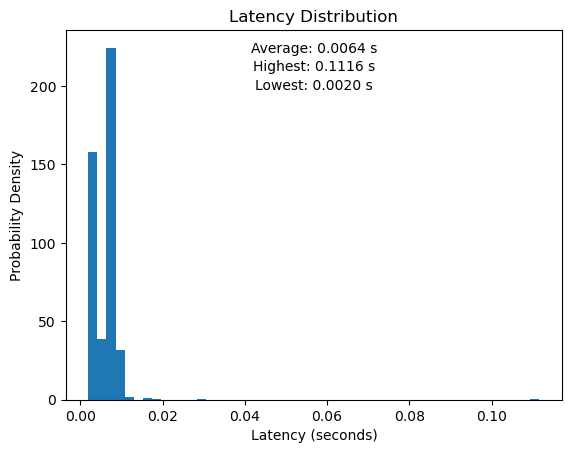

In [85]:
inference_times = []
for images, targets in trash_test_loader:
    images, targets = images.to(device), targets.to(device)
    start_time = time.time()
    with torch.no_grad():
        output = model(images)  # Add batch dimension
    inference_time = time.time() - start_time
    inference_times.append(inference_time)

# Calculate statistics
avg_inference_time = np.mean(inference_times)
max_inference_time = np.max(inference_times)
min_inference_time = np.min(inference_times)

# Plot the latency distribution
plt.hist(inference_times, bins=50, density=True)
plt.xlabel('Latency (seconds)')
plt.ylabel('Probability Density')
plt.title('Latency Distribution')

plt.text(0.5, 0.95, f'Average: {avg_inference_time:.4f} s', ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, 0.90, f'Highest: {max_inference_time:.4f} s', ha='center', va='center', transform=plt.gca().transAxes)
plt.text(0.5, 0.85, f'Lowest: {min_inference_time:.4f} s', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

In [86]:
# Measure memory footprint
with torch.no_grad():
    predictions = model(sample)
torch.cuda.reset_peak_memory_stats(device=device)
print("Memory Footprint:", torch.cuda.max_memory_allocated(device=device) / (1024 ** 2), "MB")

# Measure Inference time
start_time = time.time()
predictions = model(sample)
inference_time = time.time() - start_time
print("Inference Time:", inference_time, "seconds")

Memory Footprint: 1107.01025390625 MB
Inference Time: 0.0069768428802490234 seconds


In [87]:
# Prepare input data (batch of images)
# (Ensure the input data is in the appropriate format expected by the model)
batch_size = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Measure inference time for a batch of images
total_time = 0.0
num_iterations = 100
for _ in range(num_iterations):
    start_time = time.time()
    with torch.no_grad():
        predictions = model(sample)
    inference_time = time.time() - start_time
    total_time += inference_time

# Compute FPS throughput
average_inference_time = total_time / num_iterations
fps = batch_size / average_inference_time
print("FPS Throughput:", fps)

FPS Throughput: 7744.578530155436


In [88]:
model.eval()  # Set the model to evaluation mode
val_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in trash_test_loader:
        images, labels = images.to(device), labels.to(device)
        predictions = model(images)
        _, preds = torch.max(predictions, 1)
        val_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(val_labels, predicted_labels)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f'{conf_matrix[i, j]:.0f}\n({conf_matrix[i, j] / np.sum(conf_matrix[i]):.2%})',
            horizontalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.show()

KeyboardInterrupt: 

In [ ]:
# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters:", num_params)

# Dummy inference to measure execution time
model.eval()
with torch.no_grad():
    start_time = time.time()
    output = model(sample)
    end_time = time.time()

# Calculate GFLOPs
execution_time = end_time - start_time
flops = num_params * 2  # Assuming one FLOP for each parameter multiplication and addition
gflops = (flops / execution_time) / 1e9  # Divide by 1e9 to convert to GFLOPs
print("GFLOPs:", gflops)

In [ ]:
# model.eval()  # Set the model to evaluation mode
# val_labels = []
# predicted_labels = []
# with torch.no_grad():
#     for images, labels in trash_test_loader:
#         images = images.to(device)
#         predictions = model(images)
#         _, preds = torch.max(predictions, 1)
#         val_labels.extend(labels.cpu().numpy())
#         predicted_labels.extend(preds.cpu().numpy())

# # Create confusion matrix
# conf_matrix = confusion_matrix(val_labels, predicted_labels)

# # Plot confusion matrix
# plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
# plt.title('Confusion Matrix')
# plt.colorbar()
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')

# # for i in range(conf_matrix.shape[0]):
# #     for j in range(conf_matrix.shape[1]):
# #         plt.text(j, i, f'{conf_matrix[i, j]:.0f}\n({conf_matrix[i, j] / np.sum(conf_matrix[i]):.2%})',
# #             horizontalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

# plt.show()

In [ ]:
import torchattacks
# Attack hyperparams

epsilon = 8.0 / 255
alpha = 2.0 / 255
k = 10
beta = 1

# adversary = torchattacks.PGD(model, eps=epsilon, alpha=alpha, steps=k)

In [ ]:
# # Setup Adversarial attack 

attack = torchattacks.PGD(model=model, eps=epsilon, alpha=alpha, steps=k)

# class AttackPGD(nn.Module):
#     def __init__(self, basic_net, config):
#         super(AttackPGD, self).__init__()
#         self.basic_net = basic_net
#         self.step_size = config['step_size']
#         self.epsilon = config['epsilon']
#         self.num_steps = config['num_steps']

#     def forward(self, inputs, targets):
#         x = inputs.detach()
#         x = x + torch.zeros_like(x).uniform_(-self.epsilon, self.epsilon)
#         for i in range(self.num_steps):
#             x.requires_grad_()
#             with torch.enable_grad():
#                 loss = F.cross_entropy(self.basic_net(x), targets, size_average=False)
#             grad = torch.autograd.grad(loss, [x])[0]
#             x = x.detach() + self.step_size*torch.sign(grad.detach())
#             x = torch.min(torch.max(x, inputs - self.epsilon), inputs + self.epsilon)
#             x = torch.clamp(x, 0.0, 1.0)
#         return self.basic_net(x), x
    
# config = {
#     'step_size' : alpha,
#     'epsilon' : epsilon, 
#     'num_steps' : k
# }
# net = AttackPGD(model, config)

# if 'module' in list(checkpoint['second_net'].keys())[0]:
#     new_state_dict = {k.replace("module.", ""): v for k, v in checkpoint['second_net'].items()}
#     net.load_state_dict(new_state_dict)
# else:
#     net.load_state_dict(checkpoint['second_net'])


In [ ]:
model.eval()  # Set the model to evaluation mode
val_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in trash_test_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.enable_grad():
            adv_images = attack(images, labels)
        predictions = model(adv_images)
        _, preds = torch.max(predictions, 1)
        val_labels.extend(labels.cpu().numpy().tolist())
        predicted_labels.extend(preds.cpu().numpy().tolist())

# Create confusion matrix
conf_matrix = confusion_matrix(val_labels, predicted_labels)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f'{conf_matrix[i, j]:.0f}\n({conf_matrix[i, j] / np.sum(conf_matrix[i]):.2%})',
            horizontalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.models as models
import torch.optim as optim
import os
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, precision_score, precision_recall_curve, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


# Assuming you have test_loader containing test data
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_targets = []
    all_predictions = []
    all_probs = []
    all_adv_predictions = []
    all_adv_probs = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            
            with torch.enable_grad():
                adv_images = attack(inputs, targets)
            adv_output = model(adv_images)
            # adv_outputs = model(adv)

            _, adv_predicted = adv_output.max(1)
            all_adv_predictions.extend(adv_predicted.cpu().numpy())
            all_adv_probs.extend(torch.softmax(adv_output, dim=1).cpu().numpy())

    f1 = f1_score(all_targets, all_predictions, average='macro')
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    adv_f1 = f1_score(all_targets, all_adv_predictions, average='macro')
    adv_precision = precision_score(all_targets, all_adv_predictions, average='macro')

    # Calculate top-1 accuracy
    top1_accuracy = sum(1 for x, y in zip(all_predictions, all_targets) if x == y) / len(all_predictions)
    top1_adv_accuracy = sum(1 for x, y in zip(all_adv_predictions, all_targets) if x == y) / len(all_predictions)


    # Compute precision and recall for each class
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    precision_curve = dict()
    recall_curve = dict()
    for i in range(all_probs.shape[1]):
        precision_curve[i], recall_curve[i], _ = precision_recall_curve(all_targets == i, all_probs[:, i])

    # Compute ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(all_probs.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(all_targets == i, all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return f1, precision, top1_accuracy, fpr, tpr, roc_auc, precision_curve, recall_curve, top1_adv_accuracy, adv_f1, adv_precision, recall

# Call the evaluate_model function with your trained model and test_loader
f1, precision, top1_accuracy, fpr, tpr, roc_auc, precision_curve, recall_curve, top1_adv_accuracy, adv_f1, adv_precision, recall = evaluate_model(model, trash_test_loader)

# Plot all ROC curves in a single graph
plt.figure()
for i in range(len(fpr)):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for all classes')
plt.legend(loc="lower right")
plt.show()

# Plot all precision-recall curves in a single graph
plt.figure()
for i in range(len(precision_curve)):
    plt.plot(recall_curve[i], precision_curve[i], lw=2, label='Class {}'.format(i))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for all classes')
plt.legend(loc="best")
plt.show()

# Print other metrics
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)
print('Top-1 accuracy:', top1_accuracy)
print('Top-1 adv_accuracy:', top1_adv_accuracy)
print('adversarial F1 score:', adv_f1)
print('adversarial Precision:', adv_precision)